1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

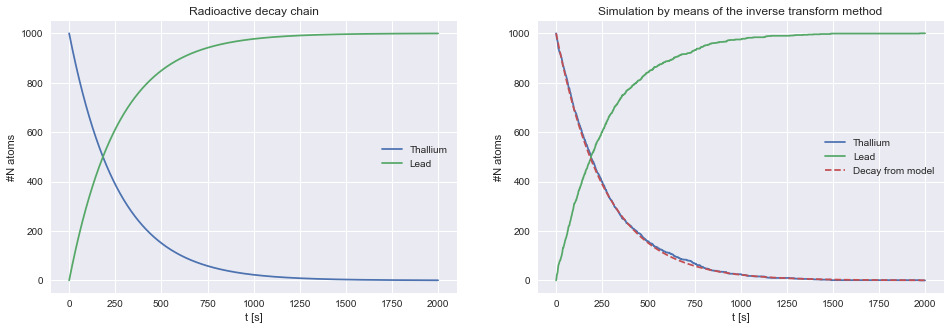

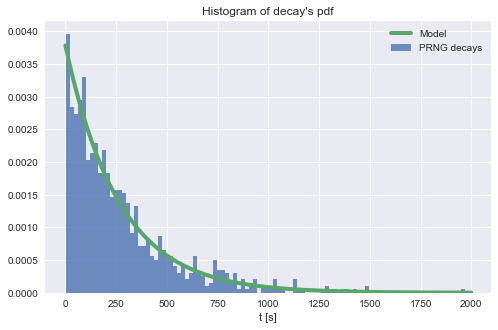

In [14]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()
t_steps = 2000
N_atoms = 1000
tau = 3.052*60
Tl = np.zeros(t_steps, dtype=np.int)
Tl[0] = N_atoms

def p(t):
    return 1 - np.power(2, -t/tau)

X = np.arange(t_steps)
Tl = N_atoms * (1-p(X))
Pb = N_atoms - Tl

# Plotting
plt.style.use("seaborn")
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].plot(X, Tl, label="Thallium")
ax[0].plot(X, Pb, label="Lead")
ax[0].set_title("Radioactive decay chain")
ax[0].set_xlabel("t [s]")
ax[0].set_ylabel("#N atoms")
ax[0].legend()

def p_pdf(t):
    return np.power(2, -t/tau)*np.log(2)/tau

def p_inv(x):
    return -tau*np.log2(1-x)

Tl_variation = np.zeros(t_steps, dtype=np.int)
samples = rng.uniform(0, 1, size=N_atoms)
samples = p_inv(samples).astype(np.int)
# (computed t) may be > (plotted max t)
samples = samples[samples < t_steps]
for s in samples:
    Tl_variation[s] += 1
Tl2 = np.zeros(t_steps, dtype=np.int)
Tl2[0] = N_atoms
for i in range(1, t_steps):
    Tl2[i] = Tl2[i-1] - Tl_variation[i]
ax[1].plot(X, Tl2, label="Thallium")
ax[1].plot(X, N_atoms-Tl2, label="Lead")
ax[1].plot(X, Tl, "--", label="Decay from model")
ax[1].set_title("Simulation by means of the inverse transform method")
ax[1].set_xlabel("t [s]")
ax[1].set_ylabel("#N atoms")
ax[1].legend()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title("Histogram of decay's pdf")
ax.set_xlabel("t [s]")
ax.hist(samples, bins=100, density=True, alpha=0.8, label="PRNG decays")
ax.plot(X, p_pdf(X), lw=4, label="Model")
_ = ax.legend()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [36]:
import numpy as np
import numpy.random as npr
from numba import jit, prange

rng = npr.default_rng()

Z = 79
e = 1.602176634E-19 #[C]
E = 7.7E6 * e #[J]
a0 = 5.291777721092E-11 #[m]
sigma = a0 / 100 #[m]
epsilon0 = 8.85418781762E-12 #[F/m]

N = int(1E6)
alpha = rng.normal(loc=0, scale=sigma, size=(N,2))
b = np.sqrt(alpha[:,0]**2 + alpha[:,1]**2)

# for nice formatting
def non_zero(x):
    return -int(np.floor(np.log10(x)))

@jit
def theta(b):
    return 2*np.arctan(Z*e**2 / (2*np.pi*epsilon0*E*b))

angles = theta(b)
bounced = np.abs(angles > np.pi/2).sum()

@jit
def calc_bounced(n=100):
    bounced = np.zeros(n)
    for i in prange(n):
        alpha = npr.normal(loc=0, scale=sigma, size=(N,2))
        b = np.sqrt(alpha[:,0]**2 + alpha[:,1]**2)
        angles = theta(b)
        bounced[i] = np.abs(angles > np.pi/2).sum()
    return bounced

bounced = calc_bounced()
std = bounced.std()
m = bounced.mean()
digits = non_zero(std/N)
std_reduced = np.round(std/N, digits)
m_reduced = np.round(m/N, digits)

print(f"Fraction of bounced back particles: {m_reduced}±{std_reduced}. \
That's {round(m)}±{round(std)} particles over {N}")

Fraction of bounced back particles: 0.00156±4e-05. That's 1559±35 particles over 1000000


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

Hit/miss method:
	Integral value = 1.4515±0.0008
Mean value method:
	Integral value = 1.4515±0.0005


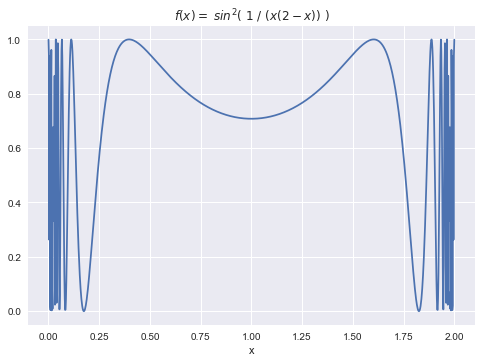

In [16]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

e = sys.float_info.epsilon
rng = np.random.default_rng()
N = 1000000

@jit
def f(x):
    return np.power(np.sin(1 / (x*(2-x))), 2)

# for nice formatting
def non_zero(x):
    return -int(np.floor(np.log10(x)))

a, b = 0, 2
x = np.linspace(a+e, b-e, 1000)
plt.style.use("seaborn")
plt.title("$f(x) = \ sin^2( \ 1 \ / \ (x(2-x)) \ )$")
plt.xlabel("x")
plt.plot(x, f(x))

# Hit/miss method
I = []
tries = 100

@jit
def montecarlo_hm():
    I = np.zeros(tries)
    for i in prange(tries):
        r = np.random.rand(N,2)
        r[:,0] *= 2
        accepted = r[:,1] <= f(r[:,0])
        count = accepted.sum()
        I[i] = 2 * count / N
    return I

I = montecarlo_hm()
sigma = I.std()
digits = non_zero(sigma)
sigma = np.round(sigma, digits)
mean = np.round(I.mean(), digits)
print("Hit/miss method:")
print(f"\tIntegral value = {mean}±{sigma}")

# Mean value method
values = f(rng.uniform(a,b,N))
I2 = 2 * values.sum() / N
std2 = 2 * values.std() / np.sqrt(N)
digits = non_zero(std2)
I2 = np.round(I2, digits)
std2 = np.round(std2, digits)
print("Mean value method:")
print(f"\tIntegral value = {I2}±{std2}")

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [14]:
from math import gamma
import numpy as np
from numba import jit, prange

rng = np.random.default_rng()

# n-dim sphere of radius r
def V(r, n):
    return np.pi**(n/2) / gamma(n/2 + 1) * r**n

# for nice formatting
def non_zero(x):
    return -int(np.floor(np.log10(x)))

@jit
def integrate(r, n):
    x = np.random.rand(N, n)
    x = x*(2*r) - r
    s = np.power(x, 2).sum(axis=1)
    count = (s <= 1).sum()
    return count * (2*r)**n / N

@jit
def calc_I(n=100):
    I2D = np.zeros(n)
    I10D = np.zeros(n)
    for i in prange(n):
        I2D[i] = integrate(1,2)
        I10D[i] = integrate(1,10)
    return I2D, I10D

I2D, I10D = calc_I()
m2D = I2D.mean()
std2D = I2D.std()
digits2D = non_zero(std2D)
std2D = np.round(std2D, digits2D)
m2D = np.round(m2D, digits2D)
m10D = I10D.mean()
std10D = I10D.std()
digits10D = non_zero(std10D)
std10D = np.round(std10D, digits10D)
m10D = np.round(m10D, digits10D)

print(f"Integral value for a 2D circle of unit radius = {m2D}±{std2D}")
print(f"\tTrue value is: {V(1,2)}")
print(f"Integral value for a 10D sphere of unit radius = {m10D}±{std10D}")
print(f"\tTrue value is: {V(1,10)}")

Integral value for a 2D circle of unit radius = 3.141±0.005
	True value is: 3.141592653589793
Integral value for a 10D sphere of unit radius = 2.5±0.1
	True value is: 2.550164039877345


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [34]:
import sys
import numpy as np

e = sys.float_info.epsilon
rng = np.random.default_rng()

def f(x):
    return np.power(x, -1/2) / (np.exp(x)+1)

def w(x):
    return 1 / np.sqrt(x)

def w_cdf(x):
    return 2 * np.sqrt(x)

def w_icdf(w):
    return np.square(w) / 4

w_int = 2
N = 100000
a, b = 0+e, 1

tries = 100
I = np.zeros(tries)
for i in range(tries):
    # We need to extract samples from w(x) distribution
    # CDF ranges from 0 to 2
    x = rng.uniform(w_cdf(a), w_cdf(b), size=N)
    x = w_icdf(x)
    I[i] = (f(x)/w(x)).sum() * w_int / N

std = I.std()
digits = -int(np.floor(np.log10(std)))
std = np.round(std, digits)
m = np.round(I.mean(), digits)
print(f"Estimated integral is: {m}±{std}")

Estimated integral is: 0.8388±0.0004
